## Regexterminator script

### To do's:
- [ ] scrape SO and/or github for common regex solutions
- [ ] scrape for common regex problems/data sets to train on
- [ ] engineer features
   - [ ] checking out text aligning tools from genetics?
   - [ ] pre-trained NN layer for parts of text/speech?
- [ ] make model work
- [ ] make flask app/website
- [ ] take in multiple inputs examples
- [ ] take in feedback
- [ ] run on a cloud server, train massive dataset
- [ ] Use reinforcement somehow? reward short answers?


### common naming mix-ups
start and original, are the sentences/stings in the raw data

end and replacement are the sentences/string after the regex is applied

sentences are the input/example/sample to emulate what the user might enter. They do not need to be sentences with words, can be numbers, jibberisht, weird strings of characters etc. Hopefully something from a regular language though...

## fun times~!

In [1]:
%qtconsole #Initiate console

In [2]:
import pandas as pd
import difflib
import re
import pickle # exporting structures for external saves and quick read back into python
import string # for counting type of characters in strings
import random


from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

In [3]:
path = "../"
path = "/Users/gregorystegeman/Documents/Regexterminator/"

# 1 Data Acquisition

In [4]:
#https://stackoverflow.com/questions/tagged/regex
'''
TODO: use stack overflow API to find top regex queries
Maybe searh for str.replace in gitHub

'''




'\nTODO: use stack overflow API to find top regex queries\nMaybe searh for str.replace in gitHub\n\n'

In [16]:
# Super simple set for easy following though pipeline here:

sample_regex_patterns = [r'[a-z]', #lowercase letters
                         r'[A-Z]', #uppercase letters
                         r'\s', #whitespace
                         r'[^A-Za-z0-9]', #no letters or numbers
                         r'[A-Za-z]', #letters any case
                         r'[0-9]', #numbers
                         r'.$', #last character
                         r'^.', #first character
                         r'^\w', #first word
                         r'\w$' #last word            
                        ]



In [6]:
sample_regex_patterns = [
    r'\d+',
    r'[a-z]',
    r'[A-Z]',
    r'\s',
    r'[^A-Za-z0-9]',
    r'[0-9]',
    r'http\S+',
    r'(.*);(.*)',
    r'^(\d{3})-(\d{3})-(\d{4})$',
    r'^(\d{3})\D+(\d{3})\D+(\d{4})\D+(\d+)$',
    r'([\w0-9_]+)',
    r'^.+',
    r'([^:：]+)[:：]?\s*',
    r'\d+/\d+/\d+',
    r'\.[0]*',
    r'[,;_]',
    r'[\w\d]{1,20}[\w]{1,20}[\w]{1,5}',
    r'(.+) \1',
    r'http\S+\s',
    r'RT|cc',
    r'[^A-Za-z0-9]+',
    r'\w',
    r'\n|\r',
    r'^([A-Za-z]\d[A-Za-z][-]?\d[A-Za-z]\d)',
    r'[:]{1}[-~+o]?[)&gt;]+',
    r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',
    r'<[^>]*>',
    r'\xA9',
    r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',
    r'@\S+',
    r'#\S+',
    r'^\d+',
    r'^[a-z]',
    r'^[A-Z]',
    r'^\s',
    r"^[^A-Za-z0-9]",
    r'^[0-9]',
    
                        ]


In [17]:
#Create dictionary to reference regex pattern classes
regex_dict = {}
for i in sample_regex_patterns:
    regex_dict['c_'+ str(sample_regex_patterns.index(i))] = i
    
#Save regex_dict in pickle; move to flask app later
pickle.dump(regex_dict, open('regex_dict.pickle', 'wb'))

Scrape/acquire sentences from: 
- [ ] twitter
- [ ] wikipedia
- [ ] yelp reviews (Ming He)
- [ ] steam game reviews
- [ ] copy from other fellows
- [ ] Excel help forums
- [ ] amazon reviews (Patrick Lestrange)
- [ ] Medium (Kim S)
- [ ] StackOverFlow comment and questions
- [ ] BGG (Pam M)

Stuff to include
- numbers
- phone numbers
- postal codes
- email address
- code segments
- dates of different formats
- IP addresses
- addresses
- multi line?
- non standard characters?


In [18]:
# smaller test dataset
start_sentences = pd.read_csv(path + 'garbage_data.csv')

start_sentences = start_sentences["garbage data"].tolist()

In [19]:
#Downloaded random dataset from https://www.figure-eight.com/data-for-everyone/
df = pd.read_csv(path + '1377191648_sentiment_nuclear_power.csv', encoding = "ISO-8859-1")

#Only really care about tweet_text column
start_sentences = start_sentences + df.tweet_text.tolist()

In [20]:
# Add in 100 sample tweets from twitter100k dataset:
tweetlines = open(path + "tweet_samples.txt").read().splitlines()

start_sentences = start_sentences + tweetlines

In [21]:
# SMS messages from:
# https://github.com/kite1988/nus-sms-corpus
import json
with open(path + "smsCorpus_en_2015.03.09_all.json") as f:
    sms_data = json.load(f)

sms = sms_data['smsCorpus']
sms = sms.get('message')

sms_texts = []
for message in sms:
    sms_texts.append(message['text']['$'])

# Maybe random later, for now keep it the same:    
sms_subset = sms_texts[0:1000]

start_sentences = start_sentences + sms_subset

In [22]:
# Generate some fake number data and then mess it up

# phone numbers

'''
754-3010 Local
(541) 754-3010 Domestic
+1-541-754-3010 International
1-541-754-3010 Dialed in the US
001-541-754-3010 Dialed from Germany
191 541 754 3010 Dialed from France
636-48018 Local
(089) / 636-48018 Domestic
+49-89-636-48018 International
19-49-89-636-48018 Dialed from France

'''



def phn():
    p=list('0000000000')
    p[0] = str(random.randint(1,9))
    for i in [1,2,6,7,8]:
        p[i] = str(random.randint(0,9))
    for i in [3,4]:
        p[i] = str(random.randint(0,8))
    if p[3]==p[4]==0:
        p[5]=str(random.randint(1,8))
    else:
        p[5]=str(random.randint(0,8))
    n = range(10)
    if p[6]==p[7]==p[8]:
        n = (i for i in n if i!=p[6])
    p[9] = str(random.choice(n))
    p = ''.join(p)
    return p[:3] + '-' + p[3:6] + '-' + p[6:]

def phnBrackets():
    p=list('0000000000')
    p[0] = str(random.randint(1,9))
    for i in [1,2,6,7,8]:
        p[i] = str(random.randint(0,9))
    for i in [3,4]:
        p[i] = str(random.randint(0,8))
    if p[3]==p[4]==0:
        p[5]=str(random.randint(1,8))
    else:
        p[5]=str(random.randint(0,8))
    n = range(10)
    if p[6]==p[7]==p[8]:
        n = (i for i in n if i!=p[6])
    p[9] = str(random.choice(n))
    p = ''.join(p)
    return '(' + p[:3] + ') ' + p[3:6] + '-' + p[6:]

def localPhn():
    p=list('0000000000')
    p[0] = str(random.randint(1,9))
    for i in [1,2,6,7,8]:
        p[i] = str(random.randint(0,9))
    for i in [3,4]:
        p[i] = str(random.randint(0,8))
    if p[3]==p[4]==0:
        p[5]=str(random.randint(1,8))
    else:
        p[5]=str(random.randint(0,8))
    n = range(10)
    if p[6]==p[7]==p[8]:
        n = (i for i in n if i!=p[6])
    p[9] = str(random.choice(n))
    p = ''.join(p)
    return p[3:6] + '-' + p[6:]

# zipcodes

# prices
"""
def priceGen():
    p=list('0000000000')
    return '$' p[3:6] + '-' + p[6:]
"""




"\ndef priceGen():\n    p=list('0000000000')\n    return '$' p[3:6] + '-' + p[6:]\n"

In [23]:
#Add to sentences a sentence that contains all alphanumeric characters that we ever expect to encounter
start_sentences.append('The quick brown fox jumped over the lazy dog')
start_sentences.append('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuv')
start_sentences.append('`1234567890-=~!@#$%^&*()_+[]\{}|;\':\",./<>?')

In [24]:
# Force all things in list to be strings

start_sentences = [str(i) for i in start_sentences]

# 2 Feature Engineering

## 2.0 Generate training data with unmodified/start sentence and a processed replacement/end sentence.

No regular expressions in feature creation!!!

In [25]:
'''
Create a new data frame that captures both the regex and also the 
sentence transformation
'''
start_regexed_end = pd.DataFrame() #Initialize empty data frame

for regex in sample_regex_patterns:
    for sentence in start_sentences:
        r = re.compile(regex)
        d = {
            'sentence': sentence,
            'regex': regex,
            'replacement': re.sub(r,'',sentence)
        }
        
        start_regexed_end = start_regexed_end.append(d, ignore_index=True)

In [26]:
# Save/pickle it, that takes a long time to run:

pickle.dump(start_regexed_end, open('start_regexed_end.pickle', 'wb'))

start_regexed_end = pickle.load(open('start_regexed_end.pickle', 'rb'))

In [27]:
# How much was changed/affected by regex's?

'''
1. Find if difference between start_regexed_end.sentence & start_regexed_end.replacement
2. Group by 'regex'
'''

#print(start_regexed_end.groupby(['regex']).sum(start_regexed_end['sentence'] != start_regexed_end['replacement']))      
start_regexed_end[start_regexed_end.sentence == start_regexed_end.replacement].groupby('regex').count()

,replacement,sentence
regex,,
[0-9],972,972
[A-Z],205,205
[A-Za-z],4,4
[^A-Za-z0-9],13,13
[a-z],8,8
\s,53,53
\w$,1117,1117
^\w,89,89


In [28]:
# Also wondering which regex give the same result from each processing.
# Which are redundant or overlapping all the time or part of the time?

In [29]:
start_regexed_end.head()

,regex,replacement,sentence
0,[a-z],! BLAH!!!,blah blah! BLAH!!!
1,[a-z],42433443,42hj43hj34hj43
2,[a-z],4.243.;;33;,4.243.gf;gfsd;3g3g;
3,[a-z],.2 3.,fdsa.2l fe3f. rlfkk
4,[a-z],.!!!,derp derp doop.!!!


## 2.1 Find differences between `start` and `end` sentence inputs

In [30]:
def charCounts(column, colname):
    """
    Counts the different type of characters in a string
    
    @param column: to apply lambda function to
    @param colname: what the unique columns should be named
    
    """
    # This is really ugly, something I could do in R very easily:
    count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

    out = column.apply(
    lambda s: pd.Series(
        {colname+'punct': count(s,set(string.punctuation)),
         colname+'letters': count(s,set(string.ascii_letters)),
         colname+'digits': count(s,set(string.digits)),
         colname+'lower': count(s,set(string.ascii_lowercase)),
         colname+'upper': count(s,set(string.ascii_uppercase)),
         colname+'whitespace': count(s,set(string.whitespace)),
         colname+'words': len(s.split()),
        }))
    return out

In [31]:
start_counts = charCounts(start_regexed_end['sentence'], 'start_n_')
end_counts = charCounts(start_regexed_end['replacement'], 'end_n_')

type_counts = pd.concat([start_regexed_end, start_counts, end_counts], axis= 1)


In [32]:
# For each column with the same suffix, find the "end" prefix column and subrtract it from the "start" prefic column.
'''
def countComparison(df)
    start_counts = charCounts(df['sentence'], 'start_n_')
    end_counts = charCounts(df['replacement'], 'end_n_')


'''


"\ndef countComparison(df)\n    start_counts = charCounts(df['sentence'], 'start_n_')\n    end_counts = charCounts(df['replacement'], 'end_n_')\n\n\n"

In [33]:
type_counts.head()

,regex,replacement,sentence,start_n_punct,start_n_letters,start_n_digits,start_n_lower,start_n_upper,start_n_whitespace,start_n_words,end_n_punct,end_n_letters,end_n_digits,end_n_lower,end_n_upper,end_n_whitespace,end_n_words
0,[a-z],! BLAH!!!,blah blah! BLAH!!!,4,12,0,8,4,2,3,4,4,0,0,4,2,2
1,[a-z],42433443,42hj43hj34hj43,0,6,8,6,0,0,1,0,0,8,0,0,0,1
2,[a-z],4.243.;;33;,4.243.gf;gfsd;3g3g;,5,8,6,8,0,0,1,5,0,6,0,0,0,1
3,[a-z],.2 3.,fdsa.2l fe3f. rlfkk,2,13,2,13,0,2,3,2,0,2,0,0,2,2
4,[a-z],.!!!,derp derp doop.!!!,4,12,0,12,0,2,3,4,0,0,0,0,2,1


## More feature engineering

sequences of similar character types (letter, number, white space and punctuation)

beginning and ends of sentences

word boundaries




In [34]:

def endChecks(dataf, start_col, end_col, regex = False):
    """
    Checks if end words and characters are the same between two strings (from columns)
    
    @param dataf: pandas dataframe.
    @param start_col: initial string
    @param end_col: modified string to compare to
    @param regex: include regex in new table for indexing.
    
    @return: returns dataframe with start column and regex for indexing, and four new columns of features
    """
    out = pd.DataFrame()
    for index, row in dataf.iterrows():
        tmp = {
            start_col: row[start_col],
            'regex': row['regex'] if regex else '',
            'first_word_same': row[start_col].split()[0] == row[end_col].split()[0] if len(row[end_col].split())>0 else False,
            'first_char_same': row[start_col][0] == row[end_col][0] if len(row[end_col].split())>0 else False,
            'last_word_same': row[start_col].split()[-1] == row[end_col].split()[-1] if len(row[end_col].split())>0 else False,
            'last_char_same': row[start_col][-1] == row[end_col][-1] if len(row[end_col].split())>0 else False,
        }
        out = out.append(tmp, ignore_index=True)
        
    return out

In [35]:
string_ends = endChecks(start_regexed_end, 'sentence','replacement', regex = True)

### more features?

position of difference

difference at beginning or end?

aligned difference?

how many words remain same?

longest run of digits, letters, etc.

proportion of characters of a class removed?

Are @'s removed?
Are #'s removed?
Are -'s removed?


# 3 Test/Train data splits

## 3.1 Feature Variables (X)

In [36]:
# Combine features I want to work with and drop the label stuff

#list(dummies.columns.values)
list(type_counts.columns.values)

features_combo = pd.merge(type_counts, string_ends, on=["sentence","regex"])

list(features_combo.columns.values)

X = features_combo.drop(['sentence', 'regex', 'replacement'], axis=1).values #Remove everything but the feature variables
X = features_combo.drop(['sentence', 'regex', 'replacement'], axis=1) #Remove everything but the feature variables





In [37]:
features_combo.head()

,regex,replacement,sentence,start_n_punct,start_n_letters,start_n_digits,start_n_lower,start_n_upper,start_n_whitespace,start_n_words,...,end_n_letters,end_n_digits,end_n_lower,end_n_upper,end_n_whitespace,end_n_words,first_char_same,first_word_same,last_char_same,last_word_same
0,[a-z],! BLAH!!!,blah blah! BLAH!!!,4,12,0,8,4,2,3,...,4,0,0,4,2,2,0.0,0.0,1.0,1.0
1,[a-z],42433443,42hj43hj34hj43,0,6,8,6,0,0,1,...,0,8,0,0,0,1,1.0,0.0,1.0,0.0
2,[a-z],4.243.;;33;,4.243.gf;gfsd;3g3g;,5,8,6,8,0,0,1,...,0,6,0,0,0,1,1.0,0.0,1.0,0.0
3,[a-z],.2 3.,fdsa.2l fe3f. rlfkk,2,13,2,13,0,2,3,...,0,2,0,0,2,2,0.0,0.0,0.0,0.0
4,[a-z],.!!!,derp derp doop.!!!,4,12,0,12,0,2,3,...,0,0,0,0,2,1,0.0,0.0,1.0,0.0


## 3.2 Target Variable (Y)

In [38]:
'''
Convert regex labels to numeric value depending on where it occurs in the sample_regex_patterns list
'''
y = ['c_'+str(sample_regex_patterns.index(i)) for i in features_combo.regex]

#Find the value (features_combo.regex) for the key in regex_dict
def findRegexClass(dict_to_search, dict_value):
    """
    Function to find the key 
    
    @param dict_to_search: The dict to search for the key for the given value
    @param dict_value: The value to find the corresponding key for
    
    @return: the key
    """
    return [key for key, value in dict_to_search.items() if dict_value == value][0]

# For each regex in dummies.regex, find the corresponding class/key to form the y-label
y = [findRegexClass(regex_dict, i) for i in features_combo.regex]

## 3.3 Test/Train data split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html
'''import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)'''

# 4 Model Fitting & Hyperparameter tuning

In [42]:
#Hyperparameter Tuning
"""
Looks like Logistic and XGBoost are performing the best. 
Tune the top 2 models and compare
"""
from skopt import BayesSearchCV

opt = BayesSearchCV(
    XGBClassifier(),
    {
        'max_depth':(4,30),#maximum depth of a tree
        'eta': (0,1),#learning rate
        'min_child_weight': (0,10), #minimum sum of instance weight ndeed in a child
        'max_delta_step': (0,10) #Step of each leaf output.
    },
    n_iter = 21
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

val. score: 0.6966292134831461
test score: 0.7032385988103106


In [44]:
"""
Get the best parameters for the XGBoost
{'eta': 0, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 10}
"""
opt.best_params_

{'eta': 0, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 10}

In [59]:
"""
Can predict features here
"""
opt.predict(X_new)

ValueError: feature_names mismatch: ['start_n_punct', 'start_n_letters', 'start_n_digits', 'start_n_lower', 'start_n_upper', 'start_n_whitespace', 'start_n_words', 'end_n_punct', 'end_n_letters', 'end_n_digits', 'end_n_lower', 'end_n_upper', 'end_n_whitespace', 'end_n_words', 'first_char_same', 'first_word_same', 'last_char_same', 'last_word_same'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']
expected start_n_upper, end_n_upper, end_n_digits, end_n_lower, end_n_punct, start_n_digits, end_n_whitespace, last_char_same, start_n_whitespace, first_word_same, start_n_punct, start_n_letters, start_n_lower, last_word_same, start_n_words, end_n_letters, first_char_same, end_n_words in input data
training data did not have the following fields: f6, f4, f8, f16, f11, f12, f13, f5, f15, f9, f0, f17, f2, f10, f7, f3, f14, f1

In [62]:
#Hyperparameter Tuning
"""
Optimize for the logistic regression
"""
from sklearn.linear_model import LogisticRegression

opt_logistic = BayesSearchCV(
    LogisticRegression(),
    {
        'C':(0.1,1),#maximum depth of a tree
    },
    n_iter = 21
)

opt_logistic.fit(X_train, y_train)

print("val. score: %s" % opt_logistic.best_score_)
print("test score: %s" % opt_logistic.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWar

val. score: 0.7293456708526107
test score: 0.7376074025115664


In [ ]:
"""
Can predict features here
"""
opt_logistic.predict(X_new)

# 4.1 Random Forest

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train, sample_weight=None, check_input=True)

cross_val_score(clf, X_train, y_train, cv=10)
#cross_val_score(clf, iris.data, iris.target, cv=10)

# grid search cv or something to find optimal parameters.


## 4.2 Boosted Gradient Tree?

XG Boost?


In [ ]:
# fit model to training data
xgb_model = XGBClassifier(nthread = -1)
xgb_model.fit(X_train, y_train)
xgbcrossval = cross_val_score(xgb_model, X_train, y_train, cv=10)

print(xgb_model)

In [ ]:
# From: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load dataset
#url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = pandas.read_csv(url, names=names)
#array = dataframe.values
X = X_train
Y = y_train
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', DecisionTreeClassifier()))
models.append(('XGBoost', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

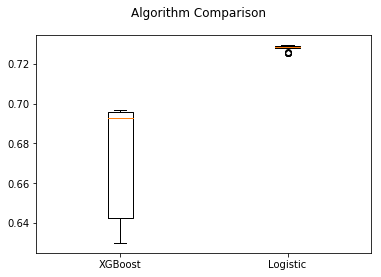

In [77]:
import matplotlib.pyplot as plt
import numpy as np

results = [opt.cv_results_['mean_test_score'], opt_logistic.cv_results_['mean_test_score']]
names = ['XGBoost','Logistic']
scoring = 'accuracy'

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 5 Model Selection

In [78]:
#Code here to pickle best model, so that it can be transfered to Flask + HTML

# save the model to disk; move this into the flask app
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

'''
# Code to load model later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
'''

"\n# Code to load model later...\n \n# load the model from disk\nloaded_model = pickle.load(open(filename, 'rb'))\n"

# 6 Predict

In [47]:
# Data to predict regex class for
a = 'a is the original sentence, b is the replacement sentence!'
b = 'a is the original sentence b is the replacement sentence'

In [48]:
# Data to predict regex class for
a = 'blah blah1 blah1114324'
b = 'blah blah blah'

In [49]:
# Data to predict regex class for
a = '4324£ ⇐'
b = '4324'

In [50]:
# Data to predict regex class for
a = "_r!e/g'e%x"
b = "regex"

In [51]:
# Data to predict regex class for
a = "Sarah Connor 518-555-2394"
b = "518-555-2394"

In [52]:
# Data to predict regex class for
a = "Sarah Connor 518-555-2394"
b = "Sarah Connor"

In [53]:
# because some of my functions from earlier need columns not raw strings:
user_inputs = {'sentence': [a], 'end': [b]}
user_inputs = pd.DataFrame(user_inputs)

# 6.1 Data Transformation
Transform the new input data to fit the model input structure

In [54]:
#add in character type counts features

a_counts = charCounts(user_inputs['sentence'], 'start_n_')
b_counts = charCounts(user_inputs['end'], 'end_n_')

input_type_counts = pd.concat([user_inputs, a_counts, b_counts], axis= 1)

#string ends feature:
string_ends = endChecks(user_inputs, 'sentence','end', regex = False)

input_features_combo = pd.merge(input_type_counts, string_ends, on="sentence")

X_new = input_features_combo.drop(['sentence','regex','end'], axis=1)

#list(input_features_combo.columns.values)

In [55]:
# As a function:
def cleanInput(a, b):
    """
    Function to perform feature transformation & engineering 

    @param a: uncleaned sentence
    @param b: desired output sentence 

    @return: feature transformed data
    """
    user_inputs = {'sentence': [a], 'end': [b]}
    user_inputs = pd.DataFrame(user_inputs)

    #add in character type counts features

    a_counts = charCounts(user_inputs['sentence'], 'start_n_')
    b_counts = charCounts(user_inputs['end'], 'end_n_')

    input_type_counts = pd.concat([user_inputs, a_counts, b_counts], axis= 1)

    #string ends feature:
    string_ends = endChecks(user_inputs, 'sentence','end', regex = False)

    input_features_combo = pd.merge(input_type_counts, string_ends, on="sentence")

    X_new = input_features_combo.drop(['sentence','regex','end'], axis=1).values

    return X_new

In [56]:
X_new = cleanInput(a,b)

X_new

array([[ 2., 11., 10.,  9.,  2.,  2.,  3.,  0., 11.,  0.,  9.,  2.,  1.,
         2.,  1.,  1.,  0.,  0.]])

## 6.2 Predict Class
TODO: For multiple inputs, find median/average highest scored class

In [51]:
#Now input into the model to predict the class
predicted_y = clf.predict(X = X_new)

In [52]:
#Match that value back to the initial class
[regex_dict.get(y) for y in predicted_y]

['^.']

In [53]:
#predicted probabilities of each class
#https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier
clf.predict_proba(X_new)[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [54]:
r = re.compile([regex_dict.get(y) for y in predicted_y][0])
print("        a:", a)
print("        b:", b)
print("predicted:", re.sub(r,'',a))
print("    using:", [regex_dict.get(y) for y in predicted_y][0])



        a: _r!e/g'e%x
        b: regex
predicted: r!e/g'e%x
    using: ^.


In [72]:
print("predicted:", re.sub(re.compile(r'...$'),'',a))

predicted: _r!e/g'


# 7 code for visualizations and explorations

In [300]:
# Visualize the decision tree:
# From https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

# Extract single tree
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: 'DecisionTreeClassifier' object has no attribute 'estimators_'

# Dumping Ground for old code snippets

In [182]:
'''
break original sentence and replacement sentence columns into character counts/presence.
'''

def characterTable(ref_sentence, sentence, regex = None):
    """
    Break up sentence by character into data frame
    
    @param ref_sentence: the original sentence, which is used as a reference. Not broken-up
    @param sentence: the sentence to break up by character
    @param: regex: the regex reference
    """
    out = pd.DataFrame(data={
        'sentence': ref_sentence,
        'regex': regex,
        'char': [i for i in sentence]
    })
    return out

start_by_char = pd.DataFrame()

for index, row in start_regexed_end.iterrows():
    chartable = characterTable(row.sentence, row.sentence, row.regex)
    start_by_char = start_by_char.append(chartable)


end_by_char = pd.DataFrame()

for index, row in start_regexed_end.iterrows():
    chartable = characterTable(row.sentence, row.replacement, row.regex)
    end_by_char = end_by_char.append(chartable)

KeyboardInterrupt: 

In [12]:
'''
Use dummies to transpose the character column into their own columns for each character.
'''
dummies_start = pd.get_dummies(start_by_char, prefix='char_start', columns=['char'])
dummies_end = pd.get_dummies(end_by_char, prefix='char_end', columns=['char'])



# Define the feature columns
r = re.compile('^char\_start\_.*')
char_start_cols = list(filter(r.match, dummies_start.columns))

dummies_start = dummies_start.groupby(['sentence','regex'])[char_start_cols].sum().reset_index()#Now sum up the values

r = re.compile('^char\_end\_.*')
char_end_cols = list(filter(r.match, dummies_end.columns))

dummies_end = dummies_end.groupby(['sentence','regex'])[char_end_cols].sum().reset_index()#Now sum up the values



In [13]:
dummies_end.head()

,sentence,regex,char_end_,char_end_!,"char_end_""",char_end_#,char_end_$,char_end_%,char_end_&,char_end_',...,char_end_|,char_end_},char_end_~,char_end_,char_end_¨,char_end_É,char_end_Ê,char_end_Ð,char_end_Ò,char_end_Õ
0,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[0-9],17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[A-Z],17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[^A-Za-z0-9],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[a-z],17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",\d+,17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
'''
Combine two dummies tables with start sentence, end sentence and regex

May need to rename some columns with strange characters
'''

# Want to combine the start_regexed_end table and the new dummies_start and dummies_end
# Should combine dummies first?
# For now keeping dummies table separate from full combo of data, 
# want to keep set of engineered features separate and combine later.

dummies_all = pd.merge(dummies_start, dummies_end, on=["sentence","regex"])



In [15]:
'''
Because the algorithms don't like when there are feature names that contain [, ] or <, just rename them
Jan 31- right now algorithm doesn't take any feature names at all.
'''

dummies = dummies_all.copy()

# Pickle dummies column names for later use; move this into the flask app
dummies_cols = dummies_all.columns
pickle.dump(dummies_cols, open('dummies_cols.pickle', 'wb'))

# rename offending columns
dummies = dummies.rename(columns={
    'char_start_[': 'char_start_left_square_bracket',
    'char_start_]': 'char_start_right_square_bracket',
    'char_start_<': 'char_start_left_carrot',
    'char_end_[': 'char_end_left_square_bracket',
    'char_end_]': 'char_end_right_square_bracket',
    'char_end_<': 'char_end_left_carrot'})

# Check it out:
list(dummies.columns.values)


['sentence',
 'regex',
 'char_start_ ',
 'char_start_!',
 'char_start_"',
 'char_start_#',
 'char_start_$',
 'char_start_%',
 'char_start_&',
 "char_start_'",
 'char_start_(',
 'char_start_)',
 'char_start_*',
 'char_start_+',
 'char_start_,',
 'char_start_-',
 'char_start_.',
 'char_start_/',
 'char_start_0',
 'char_start_1',
 'char_start_2',
 'char_start_3',
 'char_start_4',
 'char_start_5',
 'char_start_6',
 'char_start_7',
 'char_start_8',
 'char_start_9',
 'char_start_:',
 'char_start_;',
 'char_start_left_carrot',
 'char_start_=',
 'char_start_>',
 'char_start_?',
 'char_start_@',
 'char_start_A',
 'char_start_B',
 'char_start_C',
 'char_start_D',
 'char_start_E',
 'char_start_F',
 'char_start_G',
 'char_start_H',
 'char_start_I',
 'char_start_J',
 'char_start_K',
 'char_start_L',
 'char_start_M',
 'char_start_N',
 'char_start_O',
 'char_start_P',
 'char_start_Q',
 'char_start_R',
 'char_start_S',
 'char_start_T',
 'char_start_U',
 'char_start_V',
 'char_start_W',
 'char_start_X'

In [343]:
# OLD CODE FOR DUMMIES TABLE FROM USER INPUTS

'''
OLD- These features no longer work for the training set.
Make dummies table for new inputs like I did with the training data
'''
a_start = characterTable(a,a)
b_end = characterTable(a,b)

'''
Use dummies to transpose the character column into their own columns for each character.
'''
dummies_a = pd.get_dummies(a_start, prefix='char_start', columns=['char'])
dummies_b = pd.get_dummies(b_end, prefix='char_end', columns=['char'])

dummies_to_fit = dummies_to_fit.reindex(columns = dummies_cols, fill_value=0)

# Define the feature columns
r = re.compile('^char\_start\_.*')
input_char_start_cols = list(filter(r.match, dummies_a.columns))

input_dummies_start = dummies_a.groupby(['sentence'])[input_char_start_cols].sum().reset_index()#Now sum up the values

r = re.compile('^char\_end\_.*')
input_char_end_cols = list(filter(r.match, dummies_b.columns))

input_dummies_end = dummies_b.groupby(['sentence'])[input_char_end_cols].sum().reset_index()#Now sum up the values

input_dummies = pd.merge(input_dummies_start, input_dummies_end, on="sentence")

'''
Reindex the dummies table to the old columns list so the # of columns will match.
This will cause model/site to break? Seems to handle: ⇐
If the inputs have characters the model was never trained on this will cause mismatches in the number of columns.
'''
dummies_to_fit = input_dummies.reindex(columns = dummies_cols, fill_value=0)

# rename offending columns
dummies_to_fit = dummies_to_fit.rename(columns={
    'char_start_[': 'char_start_left_square_bracket',
    'char_start_]': 'char_start_right_square_bracket',
    'char_start_<': 'char_start_left_carrot',
    'char_end_[': 'char_end_left_square_bracket',
    'char_end_]': 'char_end_right_square_bracket',
    'char_end_<': 'char_end_left_carrot'})



In [34]:
'''
# More features?
# Character counts by type (number, alphabet, punct etc.)

# This is really ugly, something I could do in R very easily:
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

start_counts = start_regexed_end['sentence'].apply(
    lambda s: pd.Series(
        {'start_n_punct': count(s,set(string.punctuation)),
         'start_n_letters': count(s,set(string.ascii_letters)),
         'start_n_digits': count(s,set(string.digits)),
         'start_n_lower': count(s,set(string.ascii_lowercase)),
         'start_n_upper': count(s,set(string.ascii_uppercase)),
         'start_n_whitespace': count(s,set(string.whitespace)),
         'start_n_words': len(s.split())
        }))

end_counts = start_regexed_end['replacement'].apply(
    lambda s: pd.Series(
        {'end_n_punct': count(s,set(string.punctuation)),
         'end_n_letters': count(s,set(string.ascii_letters)),
         'end_n_digits': count(s,set(string.digits)),
         'end_n_lower': count(s,set(string.ascii_lowercase)),
         'end_n_upper': count(s,set(string.ascii_uppercase)),
         'end_n_whitespace': count(s,set(string.whitespace)),
         'end_n_words': len(s.split()),
        }))

type_counts = pd.concat([start_regexed_end, start_counts, end_counts], axis= 1)
'''

In [ ]:
#start_regexed_end.sentence[0].split() # Good for words later
start_regexed_end.sentence[0][0] #can index by character position

## 2.2 Format differences into dummy variables
1. [x] Create dummy variables for each character in sentence
2. [ ] Create a second dummy table that captures the number of deletions that occur

In [21]:
'''
For each sentence X regex combo:
1. find all the diffs, and then match the characters with dummies, and remove that amount from dummies
'''



'\nFor each sentence X regex combo:\n1. find all the diffs, and then match the characters with dummies, and remove that amount from dummies\n'

In [22]:
'''
Because the algorithms don't like when there are feature names that contain [, ] or <, just rename them
'''

dummies = dummies_original.copy()

#Pickle dummies column names for later use; move this into the flask app
dummies_cols = dummies_original.columns
pickle.dump(dummies_cols, open('dummies_cols.pickle', 'wb'))

dummies = dummies.rename(columns={'char_[': 'char_left_square_bracket', 'char_]': 'char_right_square_bracket',
                       'char_<': 'char_left_carrot'})

In [23]:
"""
Because diffs causes multiple training instances, just drop 'diff' for now and then find the column sums
"""
dummies = dummies.drop(['diffs'], axis=1) #Drop columns

#Define the feature columns
r = re.compile('^char\_.*')
char_cols = list(filter(r.match, dummies.columns))

dummies = dummies.groupby(['sentence','regex'])[char_cols].sum().reset_index()#Now sum up the values

### Features capturing differences

In [24]:
#Create dummies for the differences when they occur
'''
1. If diffs == '-', then create/find column with char
'''
sent.loc[sent.diffs=='-'].groupby(['sentence','regex','char'])['diffs'].count().reset_index()

,sentence,regex,char,diffs
0,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",",",1
1,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",0,3
2,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",1,2
3,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",2,5
4,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",3,1
5,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[ES],S,2
6,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",,17
7,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",#,2
8,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",.,1
9,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",:,1


In [ ]:
# Figuring out shit for character type counting etc.

'start_n_': count(s,set(string.)),

def mo(input1):
    return input1.count("!")+2

def mo2(input1):
    return input1.count("!") + 22


aux = start_regexed_end['sentence'].apply(lambda x: pd.Series({'feature1':mo(x), 'feature2':mo2(x)}))


modf = pd.concat([start_regexed_end, aux], axis= 1)
modf.head()


# make new df to store these features in

counts = pd.DataFrame(columns = ['sentence','regex', # for indexing
                                 'start_n_alphabet', # alphabetical characters
                                 'end_n_alphabet',
                                 'start_n_numeric', # numeric characters
                                 'end_end_numeric',
                                 'start_n_punct', # punctuations
                                 'end_n_punct'])

for index, row in start_regexed_end.iterrows():
    
    print(len([c for c in row.sentence if c.isdigit()])) # start numbers
    print(len([c for c in row.replacement if c.isdigit()])) # end numbers

    
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
count(s,set(string.punctuation))
count(s,set(string.ascii_letters))
count(s,set(string.digits))
count(s,set(string.ascii_lowercase))
count(s,set(string.ascii_uppercase))
count(s,set(string.whitespace))



# words split on whitespace?
len(s.split())

# count white space
len(s) - len(s.strip())

string.ascii_letters

string.numbers

s = 'abcd!!!'

count(s,set(string.punctuation))       
    
import string
a = "I'm not gonna post my homework as question on OS again, I'm not gonna..."

count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

a_chars =  count(a, string.ascii_letters)
a_punct = count(a, string.punctuation)

    
    
start_regexed_end.apply(lambda sentence: len([c for c in sentence if c.isdigit()]))

In [ ]:



for index, row in start_regexed_end.iterrows():
    print(len([c for c in row.sentence if c.isdigit()]))


len([c for c in s if c.isdigit()])


sum(c.isdigit() for c in s) 

# punctuations


#start_regexed_end.sentence[0].split() # Good for words later
start_regexed_end.sentence[0][0] #can index by character position

len(start_regexed_end.sentence[0])

[c for c in start_regexed_end.sentence[0] if c.isdigit()]


len([c for c in start_regexed_end.sentence[10] if c.isdigit()])


def characterTable(ref_sentence, sentence, regex = None):
    """
    Break up sentence by character into data frame
    
    @param ref_sentence: the original sentence, which is used as a reference. Not broken-up
    @param sentence: the sentence to break up by character
    @param: regex: the regex reference
    """
    out = pd.DataFrame(data={
        'sentence': ref_sentence,
        'regex': regex,
        'char': [i for i in sentence]
    })
    return out

start_by_char = pd.DataFrame()

for index, row in start_regexed_end.iterrows():
    chartable = characterTable(row.sentence, row.sentence, row.regex)
    start_by_char = start_by_char.append(chartable)



In [ ]:
'''
OLD CELL!

Cool, created this data frame with some dummy data! 
But we should create some actual features that might important, e.g., difference
'''
def calcDiffs(a,b, regex = None):
    d = difflib.Differ()
    diff = d.compare(a,b)
    tmp = list(diff)
    out = pd.DataFrame(data={
        'sentence': a,
        'regex': regex,
        #'diffs': [i[0] for i in tmp],
        'char': [i[2] for i in tmp]
    })
    
    return out

sent = pd.DataFrame()
for index, row in dat.iterrows():
    a = row.sentence
    b = row.replacement
    
    out = calcDiffs(a,b,row.regex)
    
    sent = sent.append(out)

In [ ]:





    
'''
Using the dummies table from the trained data set, reindex the new dummies to fit the same standard
https://stackoverflow.com/questions/28465633/easy-way-to-apply-transformation-from-pandas-get-dummies-to-new-data
'''
dummies_to_fit = pd.get_dummies(out, columns=['char'])

#dummies_to_fit = dummies_to_fit.reindex(columns = dummies_cols, fill_value=0)
# need to reindex on new feature set

#Rename the columns
# need to check the order this happens
dummies_to_fit = dummies_to_fit.rename(
    columns={'char_[': 'char_left_square_bracket',
             'char_]': 'char_right_square_bracket',
             'char_<': 'char_left_carrot'})

#


X_new = dummies_to_fit.drop(['sentence', 'regex',], axis=1) #Remove everything but the dummy variables

#For whatever reason it's creating a separate matrix for each one. Add them all together instead
X_new = X_new.sum().values

#Reshape data for single sample
X_new = X_new.reshape(1, -1)

#add in character type counts features

a_counts = charCounts(user_inputs['start'], 'start_n_')
b_counts = charCounts(user_inputs['end'], 'end_n_')

input_type_counts = pd.concat([user_inputs, a_counts, b_counts], axis= 1)

input_features_combo = pd.merge(input_type_counts, dummies_to_fit, on="sentence")

list(features_combo.columns.values)

